## Neural networks for segmentation

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd /content/gdrive/My Drive/Colab Notebooks/HW3

%ls

/content/gdrive/My Drive/Colab Notebooks/HW3
BBBC018_v1_images-fixed/                    saved_coeff_epoch_11
BBBC018_v1_outlines/                        saved_coeff_epoch_12
data.zip                                    saved_coeff_epoch_13
gan1.npz                                    saved_coeff_epoch_14
gan.npz                                     saved_coeff_epoch_15
homework03_part1_both.ipynb                 saved_coeff_epoch_16
homework03_part2_autoencoders_basic.ipynb   saved_coeff_epoch_17
homework03_part2_vae_advanced.ipynb         saved_coeff_epoch_18
homework03_part3a_gan_advanced.ipynb        saved_coeff_epoch_19
homework03_part3b_prd_score_advanced.ipynb  saved_coeff_epoch_2
homework03_part3_gan_basic.ipynb            saved_coeff_epoch_3
lfw_attributes.txt                          saved_coeff_epoch_4
lfw_dataset.py                              saved_coeff_epoch_5
lfw-deepfunneled/                           saved_coeff_epoch_6
linear.png                                  saved_

In [5]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2019-04-30 19:44:50--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2019-04-30 19:44:50--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1e4e6cbf1899c72bce5b2692c4.dl.dropboxusercontent.com/cd/0/inline/AgBGAwDCXWseoCiHkD2cSUmNcS0Zn8RsD9nRA5_sVtCIHrhTdU8mbK-aiSXTnCqZJ5mb68shL-AgeRV5ZZ9eBUACuhAQ6XMwpois0bmX-py5PQ/file# [following]
--2019-04-30 19:44:51--  https://uc1e4e6cbf1899c72bce5b2692c4.dl.dropboxusercontent.com/cd/0/inline/AgBGAwDCXWseoCiHkD2cSUmNcS0Zn8RsD9nRA5_sVtCIHrhTdU8mbK-aiSXTnCqZJ5mb68shL-AgeRV5ZZ9eBUACuhAQ6XMwpois0bmX-py5PQ/file
Resolving uc1e4e6cbf1899c7

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [0]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


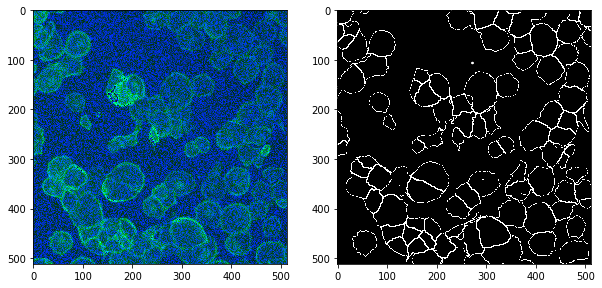

In [7]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [0]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import transforms, utils
import os
import torchvision
from torch.utils.data.dataset import Dataset  # For custom data-sets
import torchvision.transforms.functional as tf
from PIL import Image


In [0]:
import sys,os
def names(root):
  names=[]
  for path, subdirs, files in os.walk(root):
      for name in files:
          names.append(os.path.join(path, name))
  names=sorted(names)
  return names

In [0]:
images_train=names('BBBC018_v1_images-fixed/train/')
images_target_train=names('BBBC018_v1_outlines/train/')
images_val=names('BBBC018_v1_images-fixed/val/')
images_target_val=names('BBBC018_v1_outlines/val/')

In [0]:
class dataloader(Dataset):

    def __init__(self, train_path, target_path, transforms):
        
        self.train_path = train_path
        self.target_path = target_path
        self.transforms = transforms.Compose([
                                             transforms.Grayscale(1),
                                             transforms.ToTensor()])
       

    def __getitem__(self, idx):

        image = Image.open(self.train_path[idx])
        image = self.transforms(image)
        image_target = Image.open(self.target_path[idx])
        image_target = self.transforms(image_target)
        return image, image_target
    
    
    def __len__(self):
      
        return len(self.train_path)

In [0]:
batch_size=1
train_dataset = dataloader(images_train,images_target_train,transforms)   
train_batch_gen = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)

val_dataset = dataloader(images_val,images_target_val,transforms)   
val_batch_gen = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)

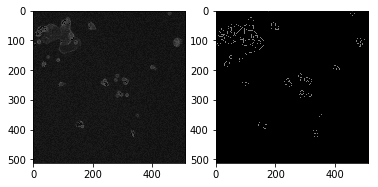

In [13]:
#source: https://discuss.pytorch.org/t/how-make-customised-dataset-for-semantic-segmentation/30881/2
def imshow(img):
    img = img / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(train_batch_gen)
images, mask = dataiter.next()
plt.subplot(1,2,1)
imshow(torchvision.utils.make_grid(images[0]))
plt.subplot(1,2,2)
imshow(torchvision.utils.make_grid(mask[0]))
plt.show()

In [0]:
#UNET neuronet
#Source: https://github.com/PARMAGroup/UNet-Instance-Cell-Segmentation/blob/master/model.py
import torch.nn as nn
import torch.nn.functional as F
import torch

""" 
    This file defines every layer (or group of layers) that are inside UNet.
    At the final the architecture UNet is defined as a conjuntion of the elements created.
"""
class double_conv(nn.Module):
    ''' Applies (conv => BN => ReLU) two times. '''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            # inplace is for aply ReLU to the original place, saving memory
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            # inplace is for aply ReLU to the original place, saving memory
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    ''' First Section of U-Net. '''

    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    ''' Applies a MaxPool with a Kernel of 2x2,
        then applies a double convolution pack. '''

    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()

        self.mpconv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    ''' Applies a Deconvolution and then applies applies a double convolution pack. '''

    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        
        # Bilinear is used to save computational cost
        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(
                in_ch//2, in_ch//2, kernel_size=2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(input=x2, pad=(diffX // 2, diffX // 2,
                                  diffY // 2, diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    ''' Applies the last Convolution to give an answer. '''

    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()

        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    ''' This Object defines the architecture of U-Net. '''

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [0]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight= torch.tensor(20.0))

In [0]:
model = UNet(1,1).cuda()


In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [23]:
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
device = torch.device("cuda")
train_loss = []

from torch.autograd import Variable
#val_loss = []

iou_mean=[]
y_pred_=[]
num_epochs = 20 # total amount of full passes over training data



for epoch in (range(num_epochs)):

    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_batch_gen:
        X_batch=Variable(X_batch,requires_grad=True).cuda()
#         print(y_batch.dtype)
        y_batch=y_batch.to(device)
        #y_batch=y_batch.float()
        #X_batch=X_batch.long()
        #y_batch=y_batch.long()
#         print(X_batch.shape)
#         print(y_batch.shape)
        # train on batch
        loss = criterion(X_batch, y_batch)
#         print(loss.dtype)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    
    
    model.train(False)
    
    for X_batch, y_batch in train_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        
        y_pred_.append(y_pred)
#         print('ggg',y_pred.dtype)
#         print('gggsss',y_batch.dtype)  
       
        iou=calc_iou(y_pred.cpu().detach().numpy(), y_batch.cpu().detach().numpy())
        iou_mean.append(np.mean(iou))
        


    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) //batch_size  :])))

    print("   iou_mean: \t{:.6f}".format(
        np.mean(iou_mean[-len(train_dataset) // batch_size :])))
   

  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-iteration): 	1.203630
   iou_mean: 	0.000000
  training loss (in-itera

In [24]:
#TRY NUMBER 2

opt = torch.optim.Adam(model.parameters(), lr=1e-2)
device = torch.device("cuda")
train_loss = []

from torch.autograd import Variable
#val_loss = []

iou_mean=[]
y_pred_=[]
num_epochs = 20 # total amount of full passes over training data



for epoch in (range(num_epochs)):

    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_batch_gen:
        X_batch=Variable(X_batch,requires_grad=True).cuda()
#         print(y_batch.dtype)
        y_batch=y_batch.to(device)
        #y_batch=y_batch.float()
        #X_batch=X_batch.long()
        #y_batch=y_batch.long()
#         print(X_batch.shape)
#         print(y_batch.shape)
        # train on batch
        loss = criterion(X_batch, y_batch)
#         print(loss.dtype)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    
    
    model.train(False)
    
    for X_batch, y_batch in train_batch_gen:
#         logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
#         y_pred = logits.max(1)[1].data
        X_batch=Variable(X_batch)
        y_batch=Variable(y_batch)
        X_batch=X_batch.to(device)
        y_batch=y_batch.to(device)
        y_pred=model(X_batch)
        y_pred_.append(y_pred)
#         print('ggg',y_pred.dtype)
#         print('gggsss',y_batch.dtype)  
       
        iou=calc_iou(y_pred.cpu().detach().numpy(), y_batch.cpu().detach().numpy())
        iou_mean.append(np.mean(iou))
        


    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) //batch_size  :])))

    print("   iou_mean: \t{:.6f}".format(
        np.mean(iou_mean[-len(train_dataset) // batch_size :])))
   

RuntimeError: ignored

In [0]:
#I dont know, i think i will resubmit it later..........